In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools
import gsw

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy
import matplotlib.ticker as ticker
from matplotlib import animation, gridspec
from matplotlib.gridspec import GridSpec

ccrs = cartopy.crs

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

# time series and maps

In [2]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_TEMP_3.0_40_20.nc').roll(nlon=+100)
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_SALT_3.0_40_20.nc').roll(nlon=+100)
ds_hmxl = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_HMXL_3.0_40_20.nc').roll(nlon=+100)
ds_shf  = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_SHF_3.0_40_20.nc').roll(nlon=+100)
ds_n_heat  = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_N_HEAT_3.0_40_20_early_hist.nc')
ds_hmxl['HMXL']=ds_hmxl.HMXL*1e-2

In [63]:
path = '/Data/skd/scratch/innag3580/comp/composites/'
ds_smoc = xr.open_dataset(os.path.join(path, f'Above_combined_smoc_3.0_40_20.nc'))
ds_dmoc = xr.open_dataset(os.path.join(path, f'Above_combined_dmoc_3.0_40_20.nc'))
ds_bsf  = xr.open_dataset(os.path.join(path, f'Above_combined_bsf_3.0_40_20.nc')).roll(nlon=+100)

In [9]:
CT = gsw.conversions.CT_from_pt(ds_salt['SALT'], ds_temp['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp['TEMP'].dims, coords=ds_temp['TEMP'].coords)

ds_dens = ds_temp
ds_dens = ds_dens.drop_vars('TEMP')
ds_dens['DENS2'] = sigma2

In [15]:
#ds_bsf = ds_bsf.assign_coords(TLAT=ds_temp.TLAT)
#ds_bsf = ds_bsf.assign_coords(TLAT=ds_temp.TLONG)

In [18]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
NA_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
NA_mask = NA_mask.sum('region')

grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [200.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [260.0, 360.0]}}]}
SPNA_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
SPNA_mask = SPNA_mask.sum('region')

## Maps

In [64]:
datasets = {
    'TEMP': ds_temp,
    'SALT': ds_salt,
    'DENS2': ds_dens,
    'HMXL': ds_hmxl,
    'SHF': ds_shf,
}

# Define the replacement value
replacement_value = 0
# Iterate over the list of datasets and replace NaN, inf, and masked values
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT']
    )
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG']
    )
    
datasets['BSF'] = ds_bsf

### TEMP, SALT, DENS2

In [38]:
variables = ['TEMP', 'SALT', 'DENS2']
labels = [r'Upper 500 meters' + '\n' + r'Temperature $\Delta$T [$^{\circ}$C]', 
          r'Upper 500 meters' + '\n' + r'Salinity $\Delta$S [$\frac{g}{kg}$]', 
          r'Upper 500 meters' + '\n' + r'Density $\Delta \sigma_2$ [$\frac{W}{m^2}$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.8, -0.3, -0.3]
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Shift (25-35 years)', 'Shift (35-45 years)', 'Post-Shift (45-55 years)']

save_name = 'Figure_Increase_Flipbooks_Hydro.png'

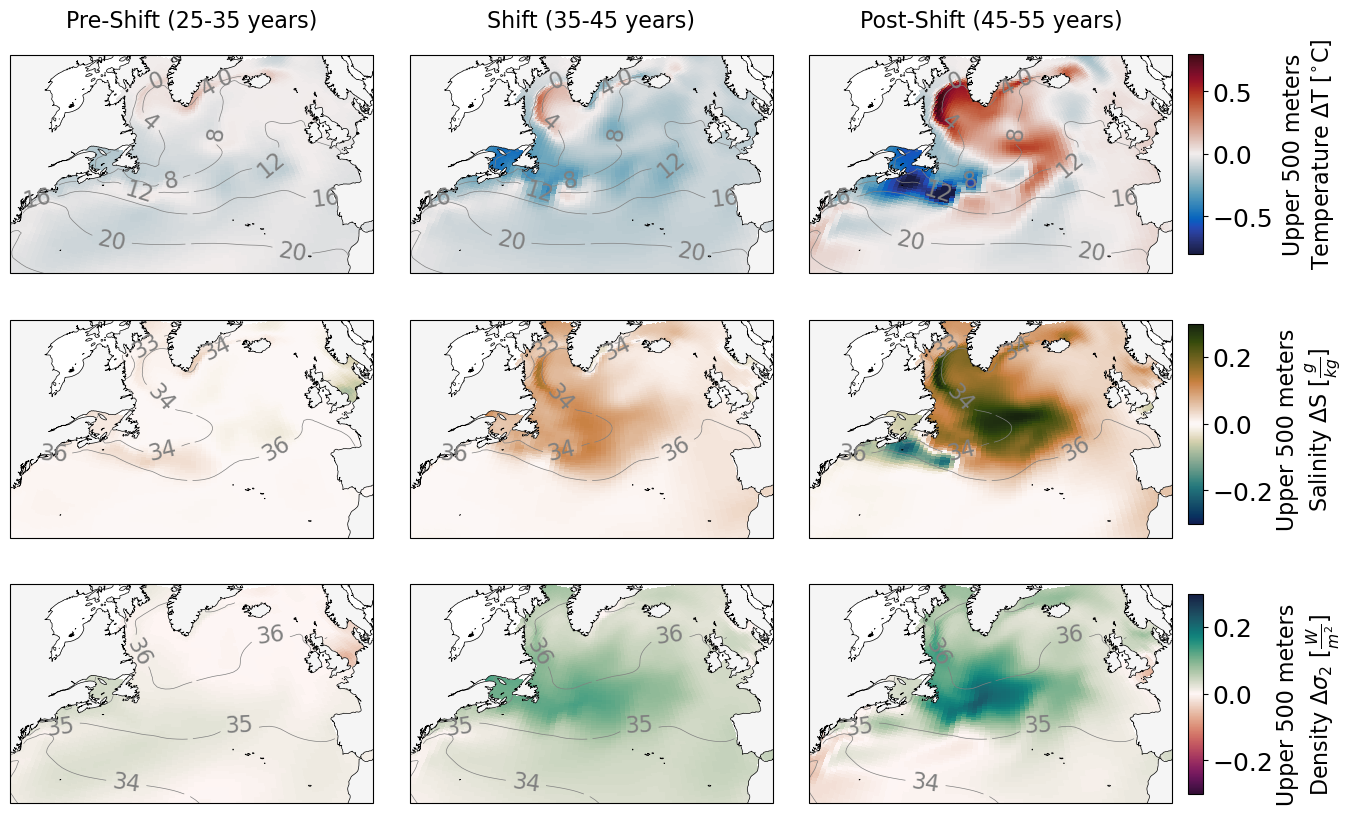

In [39]:
fontsize = 16

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), 
                         subplot_kw={'projection': ccrs.Orthographic(central_latitude=20, central_longitude=-35)})
plt.rc('font', size=18)

for col, col_name in enumerate(column_names):
    axes[0, col].set_title(col_name, fontsize=20, pad=20)

for row, var in enumerate(variables):
    ds_var_annual = datasets[var].sel(z_t=slice(0, 500)).mean('z_t')
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        da = ds.isel(time=slice(start, end)).mean('time')[var]
        pc = da.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                x='TLONG', y='TLAT',
            cmap=cmaps[row], vmin=vmin, vmax=vmax, add_colorbar=False)
        ax.set_extent([-75, -5, 30, 69], crs=ccrs.PlateCarree())
        ax.add_feature(nature_coast)

        #cs = ax.contour(ds.TLONG.where(NA_mask==1), ds.TLAT.where(NA_mask==1),
        #                ds_var_annual.isel(time=slice(0, 40)).mean('time')[var].where(NA_mask==1), 
        #                levels = np.linspace(vmin, vmax, 15),
        #                linewidths=1.5, colors='#4d4d4d', transform=ccrs.PlateCarree())
        
        cs = ax.contour(ds.TLONG, ds.TLAT, 
                        ds_var_annual.isel(time=slice(0, 40)).mean('time')[var].where(NA_mask == 1),
                        linewidths=0.5, colors='gray', transform=ccrs.PlateCarree())
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=fontsize)
        ax.set_xlabel('') 
        ax.set_ylabel('') 

cbar_axes = [fig.add_axes([0.91, 0.67 - i * 0.27, 0.01, 0.2]) for i in range(3)]
for row in range(3):
    norm = plt.Normalize(vmin=vmins[row], vmax=-vmins[row])
    sm = plt.cm.ScalarMappable(cmap=cmaps[row], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_axes[row])
    cbar.ax.set_ylabel('', fontsize=16)
for i, label in enumerate(labels):
    fig.text(0.991, 0.77 - i * 0.275, label, fontsize=fontsize, verticalalignment='center', horizontalalignment='center', rotation=90)
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=fontsize, pad=20)
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig(save_name, bbox_inches='tight', dpi=300)

plt.show()

## HMXL, SHF, BSF

In [40]:
# Sample data and variable settings
variables = ['SHF', 'HMXL', 'BSF']
labels = [r'Surface Heat Flux' + '\n' + r'$\Delta\Phi$ [$\frac{W}{m^2}$]',
          r'Mixed Layer Depth' + '\n' + r'$\Delta h$ [$m$]',
          r'Horizontal Transport Strength' + '\n' + r'$\Delta BSF$ [$Sv$]']
cmaps = [cmo.delta, 'seismic', cmo.balance]
vmins = [-200, -75, -6]
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Shift (25-35 years)', 'Shift (35-45 years)', 'Post-Shift (45-55 years)']

save_name = 'Figure_Increase_Flipbooks_Circu.png'

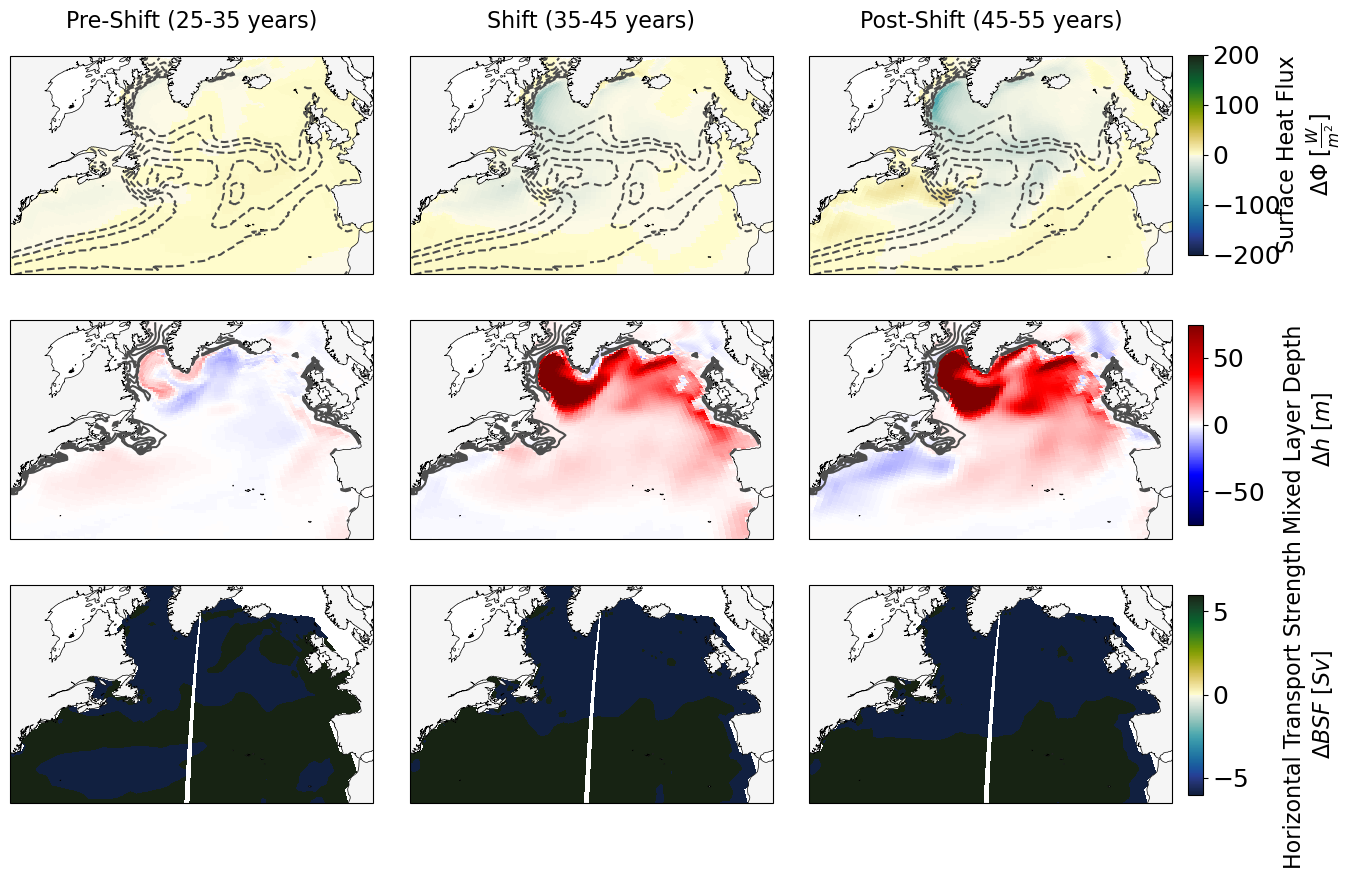

In [66]:
fontsize = 16

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), 
                         subplot_kw={'projection': ccrs.Orthographic(central_latitude=20, central_longitude=-35)})
plt.rc('font', size=18)

for col, col_name in enumerate(column_names):
    axes[0, col].set_title(col_name, fontsize=20, pad=20)
for row, var in enumerate(variables):
    ds_var_annual = datasets[var]
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        if var == 'BSF':
            da = ds.isel(time=slice(start, end)).mean('time')[var]
            contour_fill = ax.contourf(ds_temp.TLONG.where(NA_mask == 1), 
                                        ds_temp.TLAT.where(NA_mask == 1),
                                        da.where(NA_mask == 1),
                                        transform=ccrs.PlateCarree(),
                                        cmap=cmaps[row],
                                        vmin=vmin, vmax=vmax)
            cs = ax.contour(ds_temp.TLONG.where(NA_mask == 1), 
                            ds_temp.TLAT.where(NA_mask == 1),
                            ds_bsf.BSF.isel(time=0).roll(nlon=+100).where(NA_mask == 1),
                            levels=np.linspace(vmin, vmax, 15),
                            linewidths=1.5, colors='#4d4d4d', transform=ccrs.PlateCarree())
        
        else:
            da = ds.isel(time=slice(start, end)).mean('time')[var]
            pc = da.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                    x='TLONG', y='TLAT',
                                    cmap=cmaps[row],vmin=vmin, vmax=vmax,add_colorbar=False)
            cs = ax.contour(ds.TLONG.where(NA_mask==1), ds.TLAT.where(NA_mask==1),
                            ds_var_annual.isel(time=slice(0, 40)).mean('time')[var].where(NA_mask==1), 
                            levels = np.linspace(vmin, vmax, 15),
                            linewidths=1.5, colors='#4d4d4d', transform=ccrs.PlateCarree())
        ax.set_extent([-75, -5, 30, 69], crs=ccrs.PlateCarree())
        ax.add_feature(nature_coast)   
        ax.set_xlabel('') 
        ax.set_ylabel('') 
cbar_axes = [fig.add_axes([0.91, 0.67 - i * 0.27, 0.01, 0.2]) for i in range(3)]
for row in range(3):
    norm = plt.Normalize(vmin=vmins[row], vmax=-vmins[row])
    sm = plt.cm.ScalarMappable(cmap=cmaps[row], norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_axes[row])
    cbar.ax.set_ylabel('', fontsize=16)
for i, label in enumerate(labels):
    fig.text(0.991, 0.77 - i * 0.275, label, fontsize=fontsize, verticalalignment='center', horizontalalignment='center', rotation=90)
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=fontsize, pad=20)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.savefig(save_name, bbox_inches='tight', dpi=300)
plt.show()

## Timeseries

In [11]:
ds_heat = ds_temp.where(SPNA_mask == 1)
ds_fresh = ds_salt.where(SPNA_mask == 1)

In [12]:
# Define physical constants
rho_sw = 1026  # density of seawater in kg/m^3
cp_sw = 3990  # specific heat of seawater in J/(kg·K)

# Convert units to meters and square meters
ds_heat['dz'] = ds_heat.dz * 1e-2
ds_heat['UAREA'] = ds_heat.UAREA * 1e-4

# Define reference salinity
S_ref = 35  # PSU

# Convert units to meters and square meters
ds_fresh['dz'] = ds_fresh.dz * 1e-2
ds_fresh['UAREA'] = ds_fresh.UAREA * 1e-4

In [13]:
# Compute heat content
heat_content = rho_sw * cp_sw * (ds_heat.dz * ds_heat.TAREA * ds_heat.TEMP).sum(dim=['nlat', 'nlon', 'z_t'])

# Freshwater content computation (add this line)
freshwater_content = ((S_ref - ds_fresh.SALT) / S_ref * ds_fresh.dz * ds_fresh.UAREA).sum(dim=['nlat', 'nlon', 'z_t'])

In [14]:
smoc_55 = (ds_smoc.sMOC.isel(nlat=340).max('dens2')*1e-12)
dmoc_26 = (ds_dmoc.dMOC.isel(nlat=280).max('z_t')*1e-12)
bsf_spna = (ds_bsf.BSF.where(SPNA_mask == 1).min(dim=['nlat', 'nlon'])*1e-12)

In [15]:
# SPNA density 
ds_spna_dens = ds_dens.where(SPNA_mask == 1)
weights = ds_spna_dens.z_t * ds_spna_dens.TAREA
weights = weights.fillna(0)
spna_dens = ds_spna_dens.DENS2.weighted(weights).sum(dim=['nlat', 'nlon', 'z_t'])

# SPNA hmxl
ds_spna_hmxl = ds_hmxl.where(SPNA_mask == 1)
weights = ds_spna_hmxl.TAREA
weights = weights.fillna(0)
spna_hmxl = ds_hmxl.HMXL.weighted(weights).sum(dim=['nlat', 'nlon'])

# SPNA hmxl
ds_spna_shf = ds_shf.where(SPNA_mask == 1)
weights = ds_spna_shf.TAREA
weights = weights.fillna(0)
spna_shf = ds_shf.SHF.weighted(weights).sum(dim=['nlat', 'nlon'])

In [16]:
n_heat_45 = ds_n_heat.N_HEAT.isel(transport_reg=1, transport_comp=1).sel(lat_aux_grid=47.432735)

In [17]:
def normalise_time_series(timeseries):
    mean_initial = timeseries.isel(time=slice(0, 40)).mean('time')
    std_initial = timeseries.isel(time=slice(0, 40)).std('time')
    delta_timeseries = (timeseries - mean_initial) / std_initial
    return delta_timeseries

In [18]:
delta_heat_content = normalise_time_series(heat_content)
delta_freshwater_content = normalise_time_series(freshwater_content)
delta_spna_dens = normalise_time_series(spna_dens)

delta_spna_hmxl = normalise_time_series(spna_hmxl)
delta_spna_shf = normalise_time_series(spna_shf)
delta_n_heat_45 = normalise_time_series(n_heat_45)

delta_smoc_55 = normalise_time_series(smoc_55)
delta_dmoc_26 = normalise_time_series(dmoc_26)
delta_bsf_spna = normalise_time_series(bsf_spna)

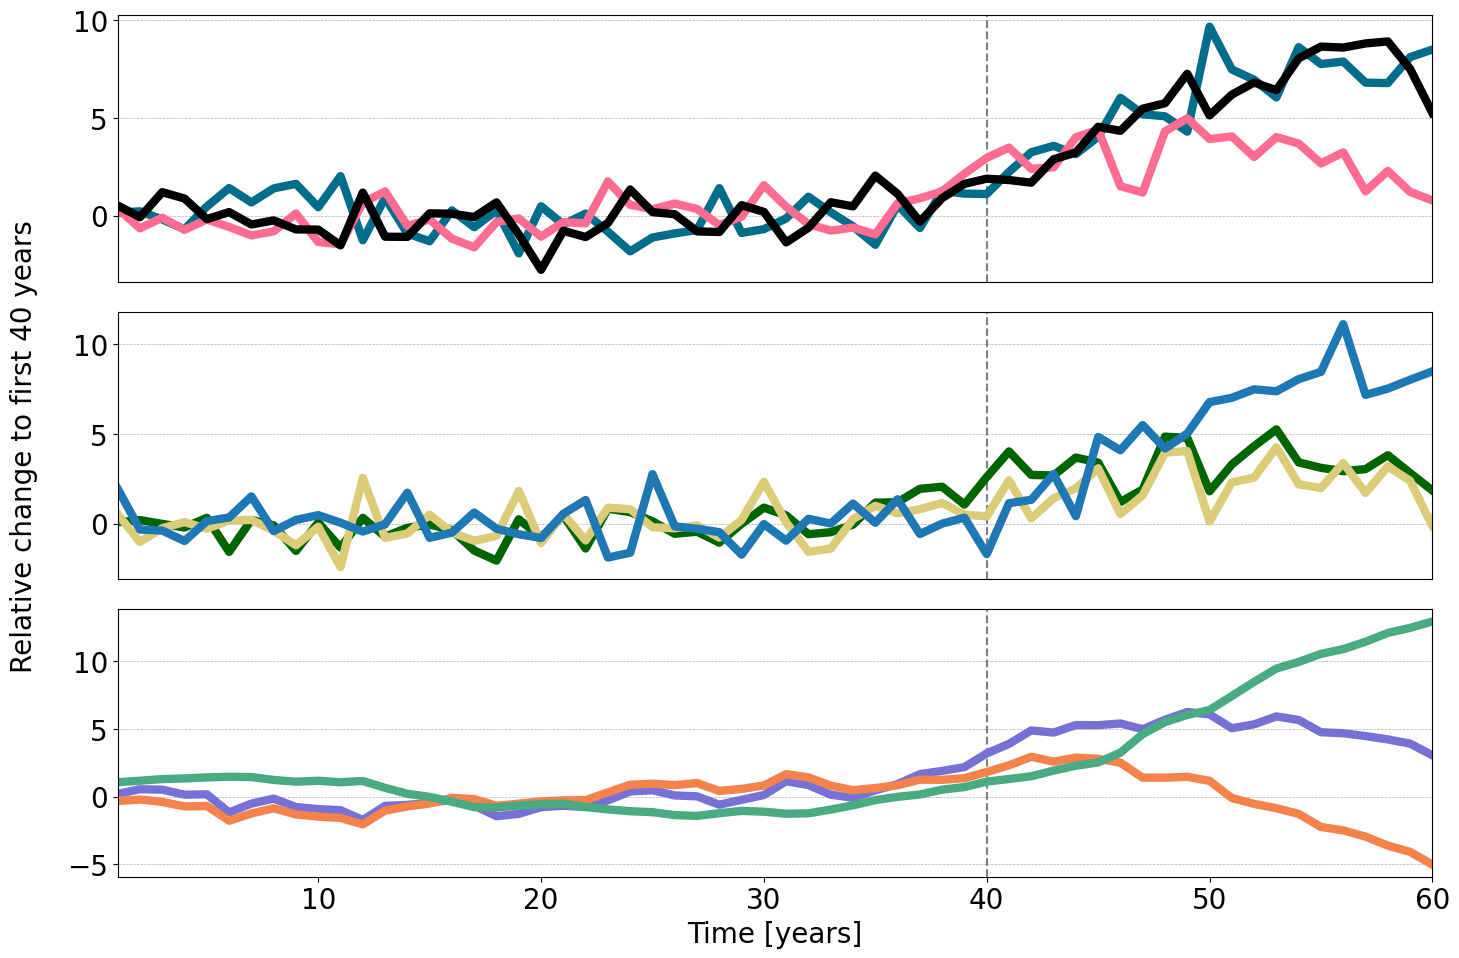

In [28]:
# Configure colors using cmocean colormap
colors = {
    'heat_content': cmo.thermal(0.7),  
    'freshwater_content': cmo.haline(0.6),  
    'spna_dens': cmo.dense(0.5),  
    'spna_hmxl': '#006400',  
    'spna_shf': '#DBCC79',
    'n_heat_45': 'tab:blue',
    'smoc_55': '#016E89',
    'bsf_spna': '#FF6C93',
    'dmoc26': 'k'
}

labelsize = 20

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
plt.rc('font', size=20)

axes[0].axvline(x=40, color='grey', linestyle='--')
axes[0].plot(delta_smoc_55.time + 1, delta_smoc_55, linewidth=6, color=colors['smoc_55'], label=r'max $\Psi_{\sigma}$ at 55°N')
axes[0].plot(delta_bsf_spna.time + 1, -delta_bsf_spna, linewidth=6, color=colors['bsf_spna'], label=r'max $\Psi_{bt}$ in SPG')
axes[0].plot(delta_dmoc_26.time + 1, delta_dmoc_26, linewidth=6, color=colors['dmoc26'], label=r'max $\Psi_{d}$ at 26°N')
axes[0].set_xlim(1, 60)
axes[0].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

axes[1].axvline(x=40, color='grey', linestyle='--')
axes[1].plot(delta_spna_hmxl.time + 1, delta_spna_hmxl, linewidth=6, color=colors['spna_hmxl'], label='Mixed Layer Depth')
axes[1].plot(delta_spna_shf.time + 1, -delta_spna_shf, linewidth=6, color=colors['spna_shf'], label='Surface Heat Flux')
axes[1].plot(delta_n_heat_45.time + 1, delta_n_heat_45, linewidth=6, color=colors['n_heat_45'], label='Heat transport at 45°')
axes[1].set_xlim(1, 60)
axes[1].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#ax2 = axes[2].twinx()
axes[2].axvline(x=40, color='grey', linestyle='--')
#ax2.plot(delta_spna_dens.time + 1, delta_spna_dens, linewidth=6, color=colors['spna_dens'], label='Density')
axes[2].plot(delta_spna_dens.time + 1, delta_spna_dens, linewidth=6, color=colors['spna_dens'], label='Density')
axes[2].plot(delta_heat_content.time + 1, -delta_heat_content, linewidth=6, color=colors['heat_content'], label='Heat Content')
axes[2].plot(delta_freshwater_content.time + 1, -delta_freshwater_content, linewidth=6, color=colors['freshwater_content'], label='Freshwater Content')
axes[2].set_xlabel('Time [years]')
axes[2].set_xlim(1, 60)
axes[2].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)

axes[1].set_ylabel('Relative change to first 40 years', fontsize=labelsize, labelpad=25)
ax2.set_ylabel(r'SPNA Density anomaly', fontsize=labelsize, labelpad=15)

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()
#plt.savefig('Figure_Increase_timeseries.png', bbox_inches='tight', dpi=300, transparent=True)

In [20]:
# Apply a 5-year sliding window average with handling for the first few years
window = 5

delta_heat_content_avg = delta_heat_content.rolling(time=window, min_periods=1).mean()
delta_freshwater_content_avg = delta_freshwater_content.rolling(time=window, min_periods=1).mean()
delta_spna_dens_avg = delta_spna_dens.rolling(time=window, min_periods=1).mean()

delta_spna_hmxl_avg = delta_spna_hmxl.rolling(time=window, min_periods=1).mean()
delta_spna_shf_avg = delta_spna_shf.rolling(time=window, min_periods=1).mean()
delta_n_heat_45_avg = delta_n_heat_45.rolling(time=window, min_periods=1).mean()

delta_smoc_55_avg = delta_smoc_55.rolling(time=window, min_periods=1).mean()
delta_dmoc_26_avg = delta_dmoc_26.rolling(time=window, min_periods=1).mean()
delta_bsf_spna_avg = delta_bsf_spna.rolling(time=window, min_periods=1).mean()

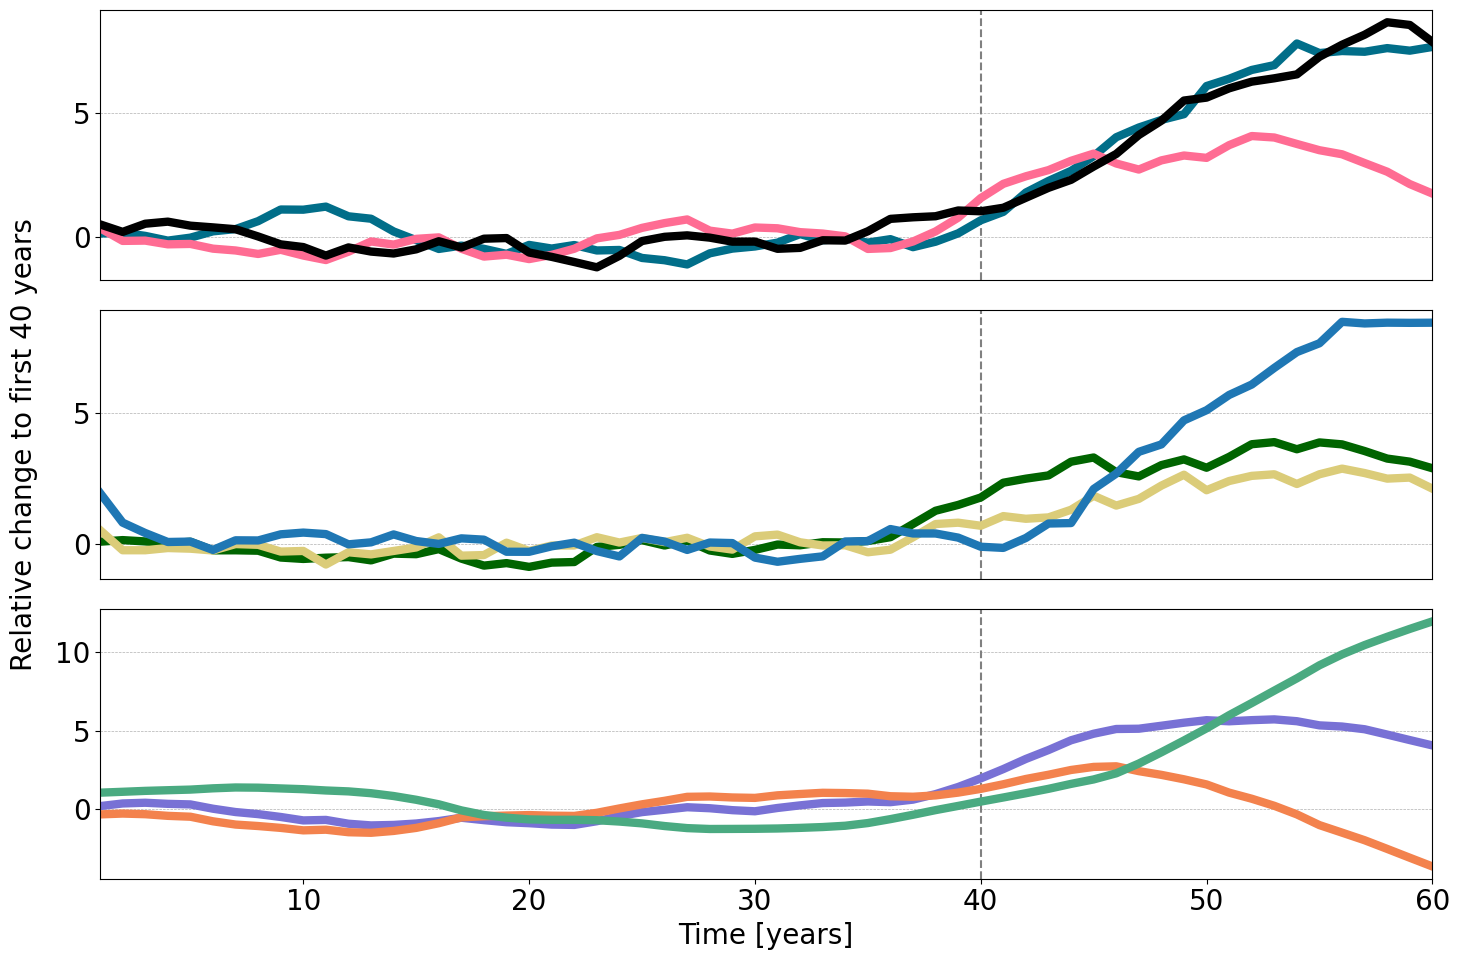

In [26]:
# Configure colors using cmocean colormap
colors = {
    'heat_content': cmo.thermal(0.7),  
    'freshwater_content': cmo.haline(0.6),  
    'spna_dens': cmo.dense(0.5),  
    'spna_hmxl': '#006400',  
    'spna_shf': '#DBCC79',
    'n_heat_45': 'tab:blue',
    'smoc_55': '#016E89',
    'bsf_spna': '#FF6C93',
    'dmoc26': 'k'
}

labelsize = 20

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
plt.rc('font', size=20)

axes[0].axvline(x=40, color='grey', linestyle='--')
axes[0].plot(delta_smoc_55_avg.time + 1, delta_smoc_55_avg, linewidth=6, color=colors['smoc_55'], label=r'max $\Psi_{\sigma}$ at 55°N')
axes[0].plot(delta_bsf_spna_avg.time + 1, -delta_bsf_spna_avg, linewidth=6, color=colors['bsf_spna'], label=r'max $\Psi_{bt}$ in SPG')
axes[0].plot(delta_dmoc_26_avg.time + 1, delta_dmoc_26_avg, linewidth=6, color=colors['dmoc26'], label=r'max $\Psi_{d}$ at 26°N')
axes[0].set_xlim(1, 60)
axes[0].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

axes[1].axvline(x=40, color='grey', linestyle='--')
axes[1].plot(delta_spna_hmxl_avg.time + 1, delta_spna_hmxl_avg, linewidth=6, color=colors['spna_hmxl'], label='Mixed Layer Depth')
axes[1].plot(delta_spna_shf_avg.time + 1,- delta_spna_shf_avg, linewidth=6, color=colors['spna_shf'], label='Surface Heat Flux')
axes[1].plot(delta_n_heat_45_avg.time + 1, delta_n_heat_45_avg, linewidth=6, color=colors['n_heat_45'], label='Heat transport at 45°')
axes[1].set_xlim(1, 60)
axes[1].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

#ax2 = axes[2].twinx()
axes[2].axvline(x=40, color='grey', linestyle='--')
#ax2.plot(delta_spna_dens_avg.time + 1, delta_spna_dens_avg, linewidth=6, color=colors['spna_dens'], label='Density')
axes[2].plot(delta_spna_dens_avg.time + 1, delta_spna_dens_avg, linewidth=6, color=colors['spna_dens'], label='Density')
axes[2].plot(delta_heat_content_avg.time + 1, -delta_heat_content_avg, linewidth=6, color=colors['heat_content'], label='Heat Content')
axes[2].plot(delta_freshwater_content_avg.time + 1, -delta_freshwater_content_avg, linewidth=6, color=colors['freshwater_content'], label='Freshwater Content')
axes[2].set_xlabel('Time [years]')
axes[2].set_xlim(1, 60)
axes[2].yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)

axes[1].set_ylabel('Relative change to first 40 years', fontsize=labelsize, labelpad=25)
ax2.set_ylabel(r'SPNA Density anomaly', fontsize=labelsize, labelpad=15)

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()
#plt.savefig('Figure_Increase_timeseries.png', bbox_inches='tight', dpi=300, transparent=True)

# Just temp, salt, dens

In [6]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
maskBSF = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
maskBSF = maskBSF.sum('region')  

In [7]:
variables = ['TEMP', 'SALT', 'DENS2']
labels = [r'Temperature Anomaly over the first 100 metres (Period 1 - Period 2)  $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly first over the first 100 metres (Period 1 - Period 2)  $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly over the first 100 metres (Period 1 - Period 2) $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.9, -0.3, -0.2]

In [8]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_TEMP_3.0_40_20.nc')
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_SALT_3.0_40_20.nc')

CT = gsw.conversions.CT_from_pt(ds_salt['SALT'], ds_temp['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp['TEMP'].dims, coords=ds_temp['TEMP'].coords)

ds_dens = ds_temp
ds_dens = ds_dens.drop_vars('TEMP')
ds_dens['DENS2'] = sigma2

In [9]:
datasets = {
    'TEMP': ds_temp.roll(nlon=+100),
    'SALT': ds_salt.roll(nlon=+100),
    'DENS2': ds_dens.roll(nlon=+100),
}

replacement_value = 0
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])

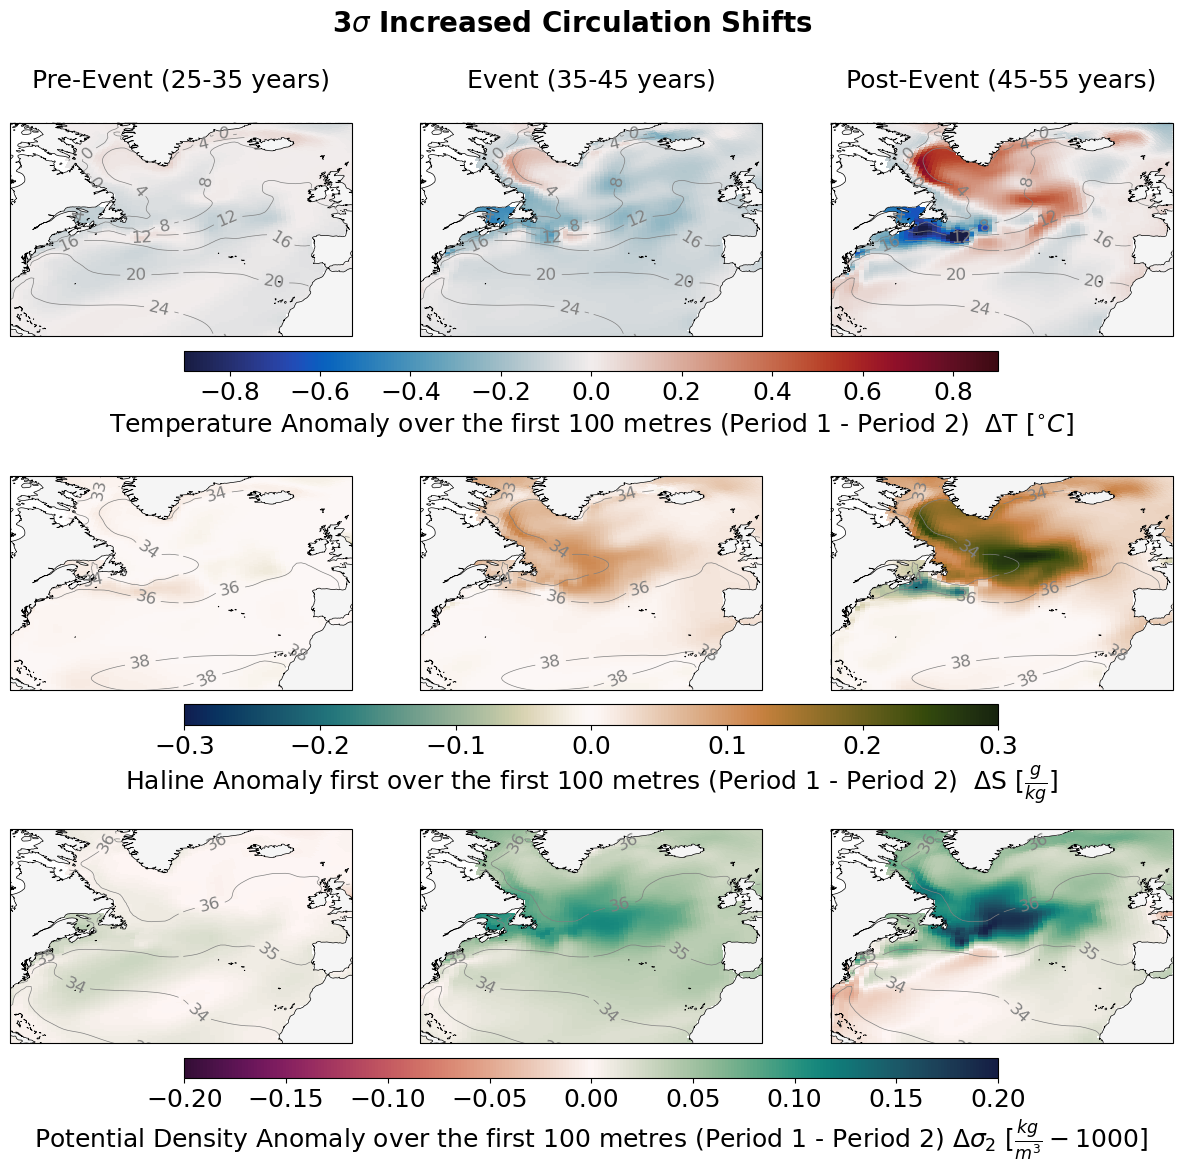

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13), # (width, height)
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Event (25-35 years)', 'Event (35-45 years)', 'Post-Event (45-55 years)']

for row, var in enumerate(variables):
    ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds[var].isel(time=range(start, end)).mean('time').plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        ax.add_feature(nature_coast)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle(r'3$\sigma$ Increased Circulation Shifts', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

#plt.show()
plt.savefig('Figure_increase_flipbooks.png', bbox_inches='tight', dpi=300)      

# temp, salt, dens, hmxl, shf

In [ ]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')  

In [ ]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_TEMP_3.0_40_20.nc')
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_SALT_3.0_40_20.nc')
ds_hmxl = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_HMXL_3.0_40_20.nc')
ds_shf  = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_SHF_3.0_40_20.nc')

In [ ]:
ds_hmxl['HMXL']=ds_hmxl.HMXL*1e-2

In [ ]:
CT = gsw.conversions.CT_from_pt(ds_salt['SALT'], ds_temp['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp['TEMP'].dims, coords=ds_temp['TEMP'].coords)

ds_dens = ds_temp
ds_dens = ds_dens.drop_vars('TEMP')
ds_dens['DENS2'] = sigma2

In [ ]:
datasets = {
    'TEMP': ds_temp.roll(nlon=+100),
    'SALT': ds_salt.roll(nlon=+100),
    'DENS2': ds_dens.roll(nlon=+100),
    'HMXL': ds_hmxl.roll(nlon=+100),
    'SHF': ds_shf.roll(nlon=+100)
}

# Define the replacement value
replacement_value = 0

# Iterate over the list of datasets and replace NaN, inf, and masked values
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT']
    )
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG']
    )

In [ ]:
variables = ['TEMP', 'SALT', 'DENS2', 'HMXL', 'SHF']
labels = [r'Temperature Anomaly over the first 100 metres (Period 1 - Period 2)  $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly first over the first 100 metres (Period 1 - Period 2)  $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly over the first 100 metres (Period 1 - Period 2) $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]',
          r'Mixed Layer Depth Anomaly (Period 1 - Period 2) $\Delta h$ [$m$]',
          r'Surface Heat Flux Anomaly (Period 1 - Period 2) $\Delta\Phi$ [$\frac{W}{m^2}$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, 'seismic', cmo.delta]
vmins = [-1, -0.4, -0.3, -200, -75]

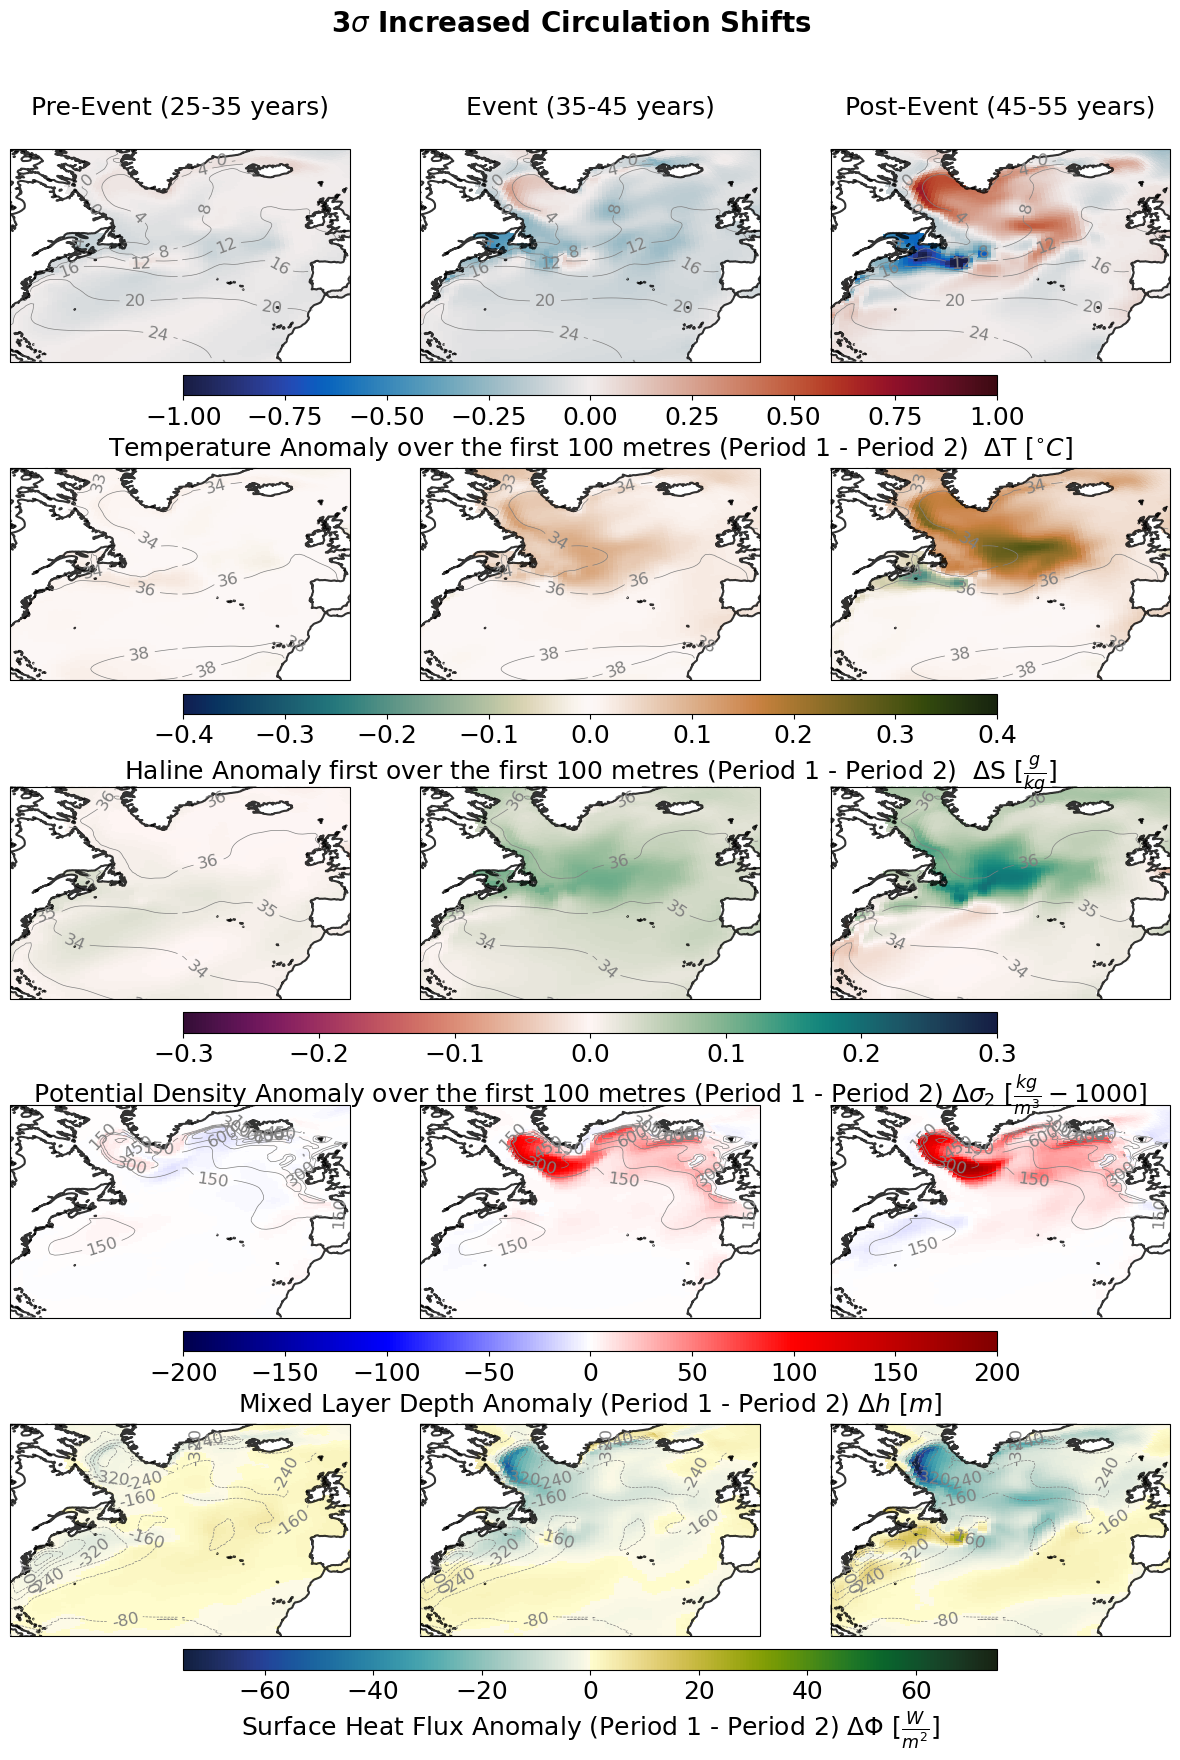

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20),  # Adjusted height for 5 rows
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Event (25-35 years)', 'Event (35-45 years)', 'Post-Event (45-55 years)']

for row, var in enumerate(variables):
    if var in ['HMX', 'SHF']:
        ds_var_annual = datasets[var]
    else:
        ds_var_annual = datasets[var].sel(z_t=slice(500, 10500)).mean('z_t')
    
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds.isel(time=slice(start, end)).mean('time')[var].plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual.isel(time=slice(0, 40)).mean('time')[var].where(mask == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle(r'3$\sigma$ Increased Circulation Shifts', fontsize=20, fontweight='bold', x=0.5, y=0.95)  # bottom-left (0, 0) and top-right (1, 1)

#plt.show()
plt.savefig('Figure_increase_flipbooks.png', bbox_inches='tight', dpi=300, transparent=True)      

# Plot heat and freshwater content

In [2]:
ds_temp = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_TEMP_3.0_40_20.nc').roll(nlon=+100)
ds_salt = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Above_combined_SALT_3.0_40_20.nc').roll(nlon=+100)

In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic': [
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [200.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [50.0, 65.0], 'TLONG': [260.0, 360.0]}}
    ]
}

# Create mask for selected regions
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask = mask.sum('region')

ds_temp = ds_temp.where(mask == 1)
ds_salt = ds_salt.where(mask == 1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# Define physical constants
rho_sw = 1026  # density of seawater in kg/m^3
cp_sw = 3990  # specific heat of seawater in J/(kg·K)

# Convert units to meters and square meters
ds_temp['dz'] = ds_temp.dz * 1e-2
ds_temp['UAREA'] = ds_temp.UAREA * 1e-4

# Define reference salinity
S_ref = 35  # PSU

# Convert units to meters and square meters
ds_salt['dz'] = ds_salt.dz * 1e-2
ds_salt['UAREA'] = ds_salt.UAREA * 1e-4

In [5]:
# Compute heat content
heat_content = rho_sw * cp_sw * (ds_temp.dz * ds_temp.UAREA * ds_temp.TEMP).sum(dim=['nlat', 'nlon', 'z_t'])

# Freshwater content computation (add this line)
freshwater_content = ((S_ref - ds_salt.SALT) / S_ref * ds_salt.dz * ds_salt.UAREA).sum(dim=['nlat', 'nlon', 'z_t'])

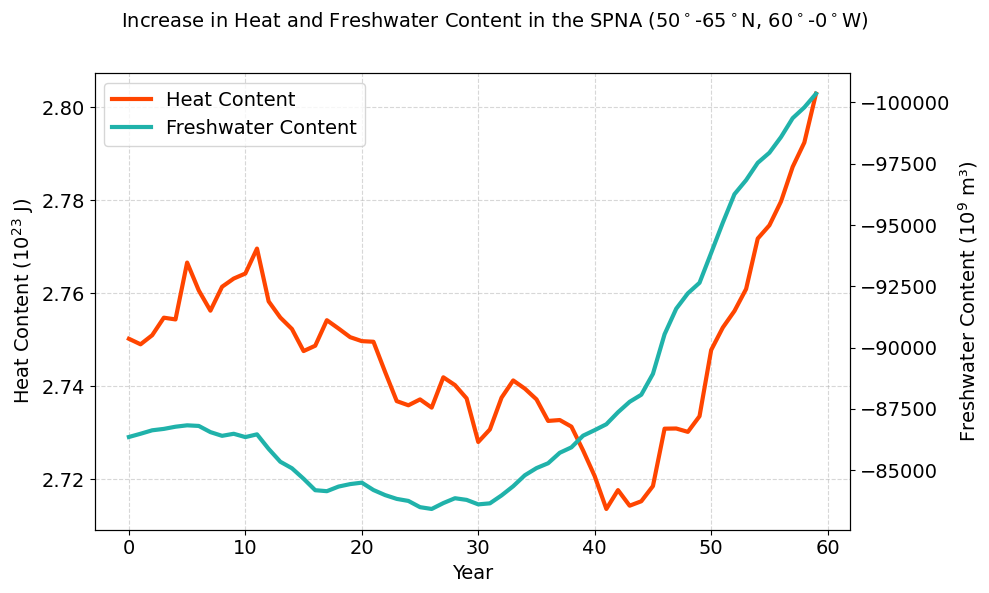

In [6]:
# Define a consistent font size
fontsize = 14

# Define the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot heat content time series
ax1.plot(heat_content.time, heat_content / 1e23, color='orangered', label='Heat Content', linewidth = 3)
ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('Heat Content ($10^{23}$ J)', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Twin axis for freshwater content and flip y-axis
ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.plot(freshwater_content.time, freshwater_content / 1e9, color='lightseagreen', label='Freshwater Content', linewidth = 3)
ax2.set_ylabel('Freshwater Content ($10^9$ m³)', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=fontsize)

# Title
fig.suptitle(r'Increase in Heat and Freshwater Content in the SPNA (50$^\circ$-65$^\circ$N, 60$^\circ$-0$^\circ$W)', fontsize=fontsize)

# Grid and Layout
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
#plt.savefig('Figure_increase_content.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [25]:
from matplotlib.collections import LineCollection

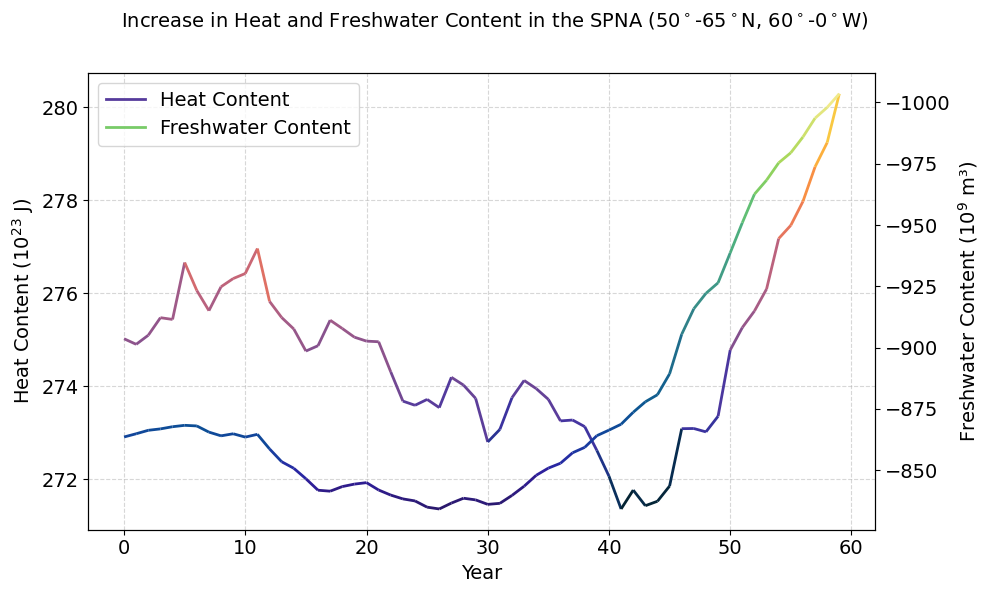

In [39]:
# Define a consistent font size
fontsize = 14

# Custom color ranges
colors_heat = cmo.thermal(np.linspace(0, 0.5, 100))
colors_freshwater = cmo.haline_r(np.linspace(0, 0.5, 100))

# Define the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot heat content time series with color gradient
points_heat = np.array([heat_content.time, heat_content / 1e23]).T.reshape(-1, 1, 2)
segments_heat = np.concatenate([points_heat[:-1], points_heat[1:]], axis=1)
lc_heat = LineCollection(segments_heat, cmap=cmo.thermal, norm=None)  # No norm
lc_heat.set_array(heat_content / 1e23)
lc_heat.set_linewidth(2)
ax1.add_collection(lc_heat)
ax1.autoscale_view()

ax1.set_xlabel('Year', fontsize=fontsize)
ax1.set_ylabel('Heat Content ($10^{23}$ J)', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Twin axis for freshwater content and invert y-axis
ax2 = ax1.twinx()
points_freshwater = np.array([freshwater_content.time, freshwater_content / 1e9]).T.reshape(-1, 1, 2)
segments_freshwater = np.concatenate([points_freshwater[:-1], points_freshwater[1:]], axis=1)
lc_freshwater = LineCollection(segments_freshwater, cmap=cmo.haline_r, norm=None)  # No norm
lc_freshwater.set_array(freshwater_content / 1e9)
lc_freshwater.set_linewidth(2)
ax2.add_collection(lc_freshwater)
ax2.autoscale_view()
ax2.invert_yaxis()

ax2.set_ylabel('Freshwater Content ($10^9$ m³)', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Combine legends
custom_legend = [
    plt.Line2D([0], [0], color=colors_heat[50], lw=2, label='Heat Content'),
    plt.Line2D([0], [0], color=colors_freshwater[50], lw=2, label='Freshwater Content')
]
ax1.legend(custom_legend, ['Heat Content', 'Freshwater Content'], loc='upper left', fontsize=fontsize)

# Title
fig.suptitle(r'Increase in Heat and Freshwater Content in the SPNA (50$^\circ$-65$^\circ$N, 60$^\circ$-0$^\circ$W)', fontsize=fontsize)

# Grid and Layout
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
#plt.savefig('Figure_increase_content.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()